In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

In [3]:
customer_profile = merged_data.groupby('CustomerID').agg({'TotalValue': 'sum','TransactionID': 'count','ProductID': 'nunique','TransactionDate': 'max'  }).reset_index().rename(columns={'TransactionID': 'TransactionCount','ProductID': 'UniqueProducts','TransactionDate': 'LastTransactionDate'})

customer_profile['LastTransactionDate'] = pd.to_datetime(customer_profile['LastTransactionDate'])
customer_profile['DaysSinceLastTransaction'] = (pd.to_datetime('today') - customer_profile['LastTransactionDate']).dt.days

In [4]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(customer_profile[['TotalValue', 'TransactionCount', 'UniqueProducts', 'DaysSinceLastTransaction']])
similarity_matrix = cosine_similarity(features_scaled)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profile['CustomerID'], columns=customer_profile['CustomerID'])

In [5]:
def get_top_lookalikes(customer_id, threshold=0.8, top_n=3):
    similar_customers = similarity_df[customer_id]
    similar_customers = similar_customers[similar_customers > threshold]
    similar_customers = similar_customers.nlargest(top_n + 1)
    similar_customers = similar_customers[similar_customers.index != customer_id]
    return similar_customers.index.tolist(), similar_customers.values.tolist()

lookalike_recommendations = {}
for customer_id in customer_profile['CustomerID'][:20]:
    lookalikes, scores = get_top_lookalikes(customer_id)
    lookalike_recommendations[customer_id] = list(zip(lookalikes, scores))

lookalike_data = []
for customer_id, recommendations in lookalike_recommendations.items():
    for lookalike, score in recommendations:
        lookalike_data.append([customer_id, lookalike, score])

lookalike_df = pd.DataFrame(lookalike_data, columns=['CustomerID', 'LookalikeCustomerID', 'SimilarityScore'])
lookalike_df.to_csv('Lookalike.csv', index=False)

In [6]:
for customer_id, recommendations in lookalike_recommendations.items():
    print(f"Customer ID: {customer_id}")
    for lookalike, score in recommendations:
        print(f"  Lookalike: { lookalike}, Similarity Score: {score:.4f}")

Customer ID: C0001
  Lookalike: C0190, Similarity Score: 0.9895
  Lookalike: C0191, Similarity Score: 0.9893
  Lookalike: C0056, Similarity Score: 0.9882
Customer ID: C0002
  Lookalike: C0031, Similarity Score: 0.9979
  Lookalike: C0083, Similarity Score: 0.9862
  Lookalike: C0029, Similarity Score: 0.9855
Customer ID: C0003
  Lookalike: C0112, Similarity Score: 0.9992
  Lookalike: C0097, Similarity Score: 0.9988
  Lookalike: C0144, Similarity Score: 0.9984
Customer ID: C0004
  Lookalike: C0136, Similarity Score: 0.9944
  Lookalike: C0068, Similarity Score: 0.9937
  Lookalike: C0122, Similarity Score: 0.9909
Customer ID: C0005
  Lookalike: C0123, Similarity Score: 0.9998
  Lookalike: C0036, Similarity Score: 0.9987
  Lookalike: C0078, Similarity Score: 0.9950
Customer ID: C0006
  Lookalike: C0168, Similarity Score: 0.9052
  Lookalike: C0026, Similarity Score: 0.8734
  Lookalike: C0066, Similarity Score: 0.8629
Customer ID: C0007
  Lookalike: C0120, Similarity Score: 0.9923
  Lookalike:

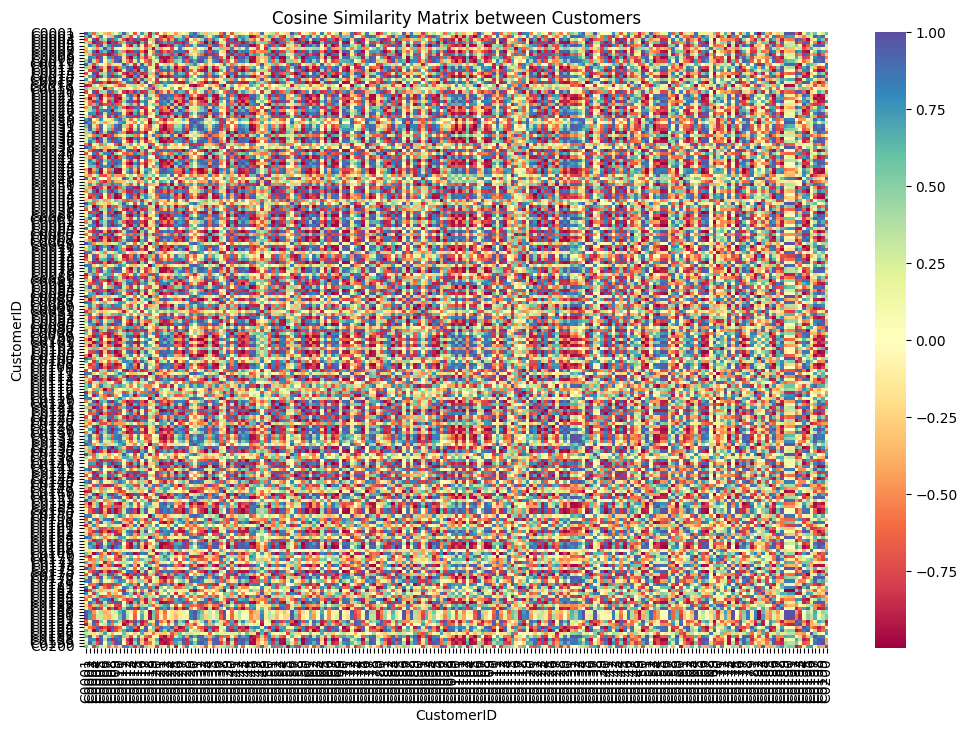

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, cmap='Spectral', xticklabels=customer_profile['CustomerID'], yticklabels=customer_profile['CustomerID'], annot=False)
plt.title('Cosine Similarity Matrix between Customers')
plt.xlabel('CustomerID')
plt.ylabel('CustomerID')
plt.show()